# Compare K-Means Seeding Against Choosing N Points at Random

K-means++ maximises the spread between N centroids, and does so according to a weight function.
ADD IMAGE HERE

In [43]:
""" Define the root directories for each set of calculations, and the data set

All single node jobs. 4 MPI, 8 OMP per process
"""
%load_ext autoreload
%autoreload 2

import numpy as np
from pathlib import Path
import re
from typing import List

from isdfbenchmarks.parser import static
from isdfbenchmarks.parser.stdout import parse_exchange_energy


# Old sets of reference data
# No OMP support
# root_kmeanspp_l2 = Path("/home/bucchera/exchange_calcs/kmeans_plus_plus")
# OMP support, but prior to the refactor that removes k iterations.
# root_omp_kmeanspp_l2 = Path("/home/bucchera/exchange_calcs/omp_kmeans_plus_plus")
# Should really be called Fisher-Yates. Superseded by a single reference
# root_kmeans_l2 = Path("/home/bucchera/exchange_calcs/kmeans_l2")

# ACE reference data
root_ace_ref = Path("/home/bucchera/exchange_calcs/ace_references")

# ISDF exact exchange energies 
# Seeded with FY. Weighted kmeans only run for first SCF step
root_fy_wkm_once = Path("/home/bucchera/exchange_calcs/nisdf_vector_scaling")
# Seeded with kmeans++. Weighted kmeans only run for first SCF step
root_kmeanspp_wkm_once = Path("/home/bucchera/exchange_calcs/kmeanspp_nisdf_vector_scaling")
# Seeded with FY. Weighted kmeans run for all SCF
root_fy_wkm_all = Path("/home/bucchera/exchange_calcs/fy_all_itrs")
# Seeded with kmeans++. Weighted kmeans run for all SCF
root_kmeanspp_wkm_all = Path("/home/bucchera/exchange_calcs/kmeanspp_all_itrs")


## Number of K-Means per SCF step 


In [44]:
def parse_kmeans_iterations(path) -> List[int]:
    pat = re.compile(r'^Kmeans converged in\s+(\d+)\s+iterations\b',
                     re.IGNORECASE | re.MULTILINE)
    
    with open(path, "r", encoding="utf-8") as fid:
        text = fid.read()
    
    # All iteration counts as ints
    return np.array([int(n) for n in pat.findall(text)])


def parse_kmeans_set(root, directories) -> dict:
    iters = {}
    for dir in directories:
        iters[dir] = parse_kmeans_iterations(root / dir / "terminal.out")
    return iters


def parse_exx(root, directories) -> dict:
    """ Parse the final exact exchange energy from a calculation
    :param root: 
    :param directories: 
    :return: 
    """
    exx = {}
    for dir in directories:
        exx[dir] = static.info_file(root / dir)['Energy']['Exchange']
    return exx


def parse_exx_convergence(root: Path, directories: list) -> dict:
    exx_convergence = {}
    for dir in directories:
        with open(root / dir / "terminal.out", "r", encoding="utf-8") as fid:
            text = fid.read()
        exx_convergence[dir] = np.array([e for e in parse_exchange_energy(text).values()])
    return exx_convergence

In [69]:
""" Plot the data
"""
import matplotlib.pyplot as plt
import numpy as np


def plot_kmeans_iters_grid(molecules, data1, data2):
    """
    Plot up to 4 molecules in a 2x2 subplot grid.
    """
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes_flat = axes.ravel()  # flatten to 1D array for easy indexing

    for i, molecule in enumerate(molecules):
        ax = axes_flat[i]

        x1 = np.arange(len(data1[molecule]), dtype=int)
        ax.plot(x1,
                data1[molecule],
                'ro--',
                linewidth=2,
                markersize=8,
                label='FisherYates')

        x2 = np.arange(len(data2[molecule]), dtype=int)
        ax.plot(x2,
                data2[molecule],
                'bo--',
                linewidth=2,
                markersize=8,
                label='KMeans++')

        ax.set_title(molecule)
        ax.set_xlabel("SCF Iteration")
        ax.set_ylabel("Number of Kmeans Iterations")
        ax.legend(title='Seeding')

    # Remove unused axes if fewer than 4 molecules
    for j in range(len(molecule), 4):
        fig.delaxes(axes_flat[j])

    fig.tight_layout()
    return fig, axes


In [70]:
""" Parse the data
"""
molecules = ['anthracene', 'tetracene', 'pentacene', 'ether_crown']
isdf_basis = ['5_nocc', '7.5_nocc', '10_nocc', '15_nocc']

# Weighted kmeans iterations as a function of seed method (and ISDF basis size)
fy_kmeans_itrs = {}
kmeanspp_kmeans_itrs = {}
for subdir in isdf_basis:
    fy_kmeans_itrs[subdir] = parse_kmeans_set(root_fy_wkm_all / subdir, molecules)
    kmeanspp_kmeans_itrs[subdir] = parse_kmeans_set(root_kmeanspp_wkm_all / subdir, molecules)


Text(0.5, 1.02, 'ISDF NVectors = 15 $N_{\\text{occ}}$')

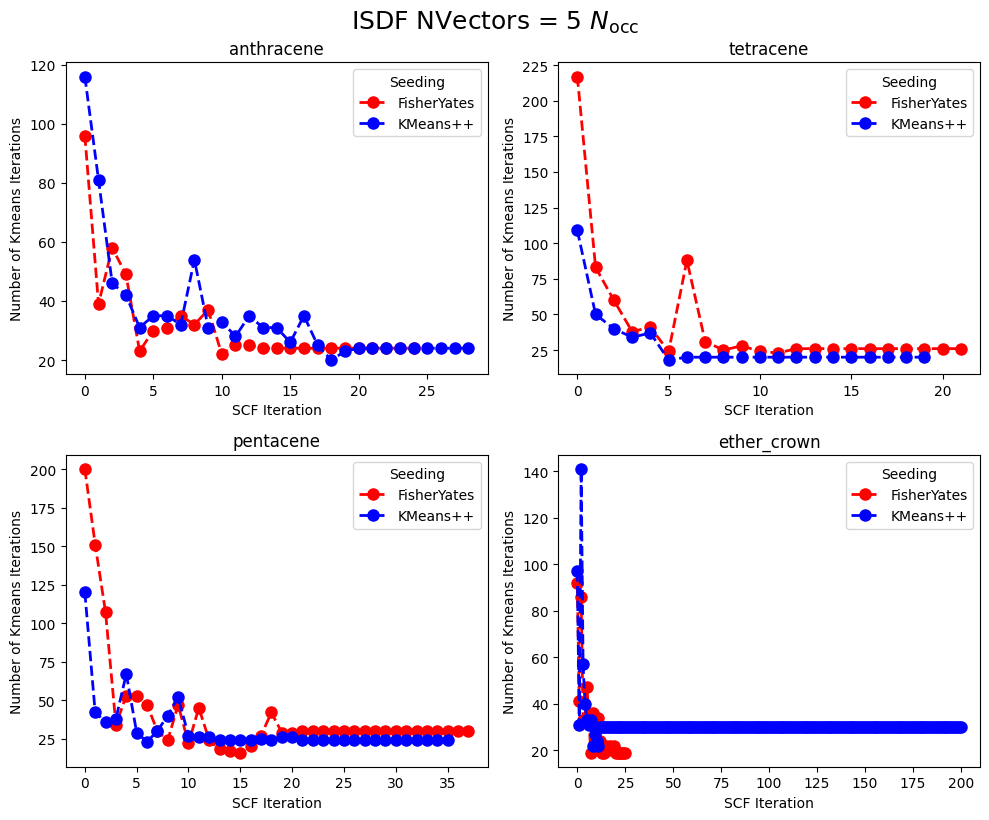

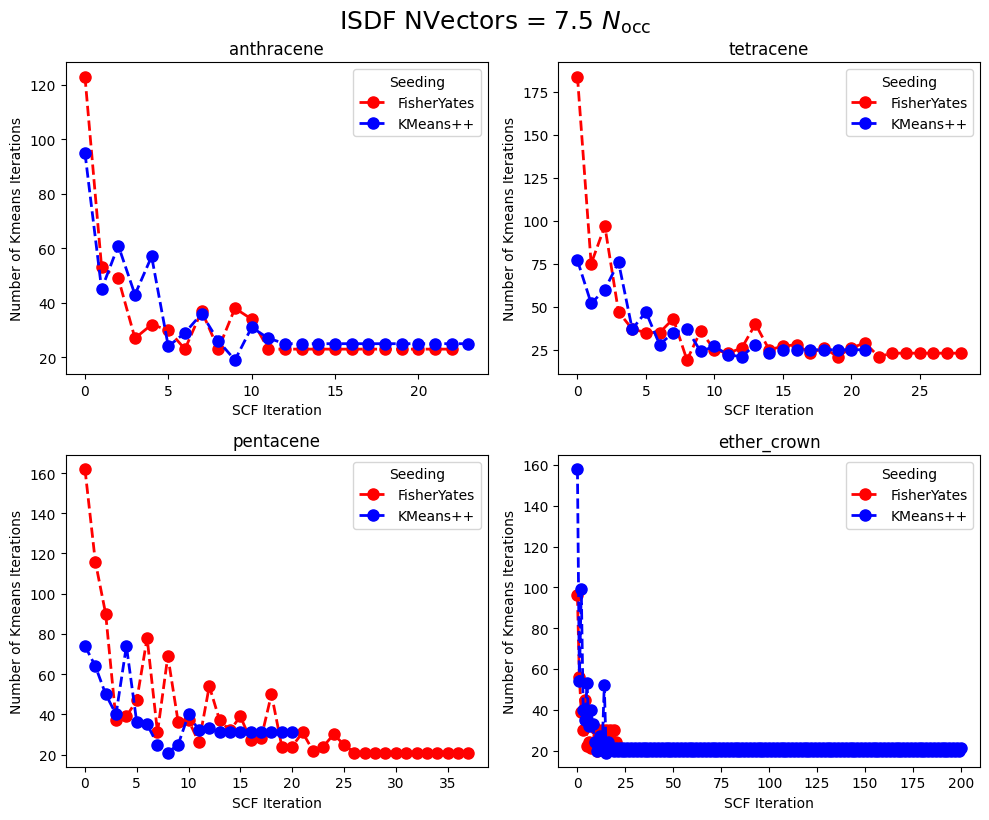

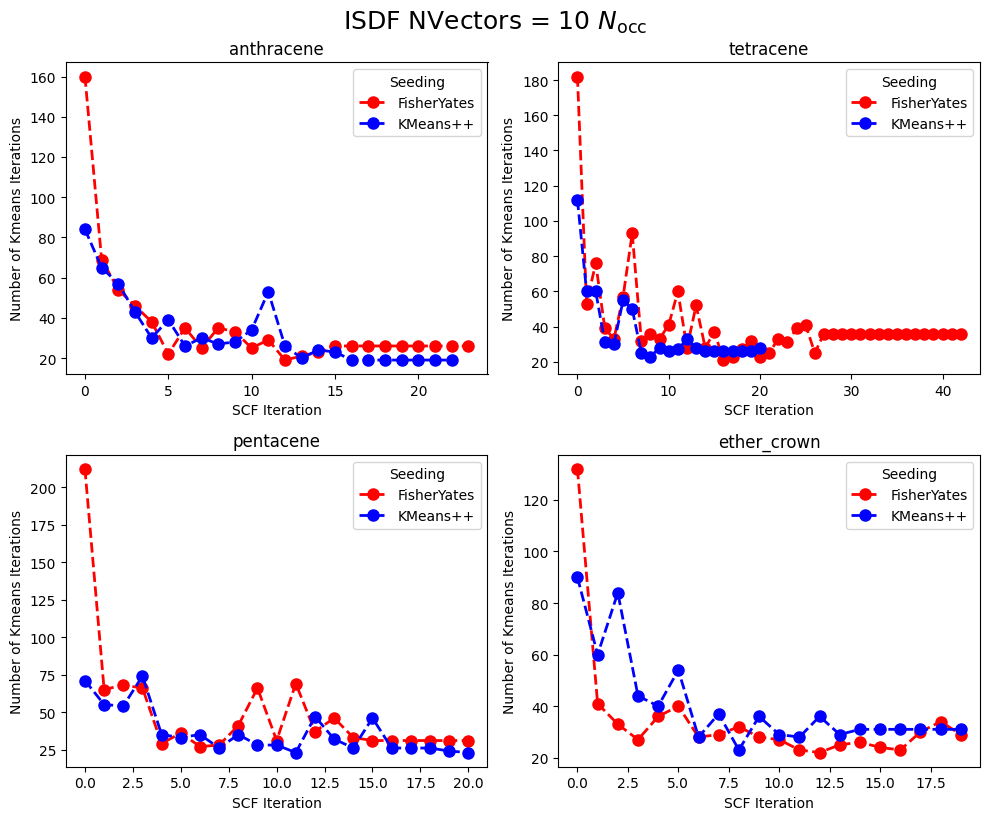

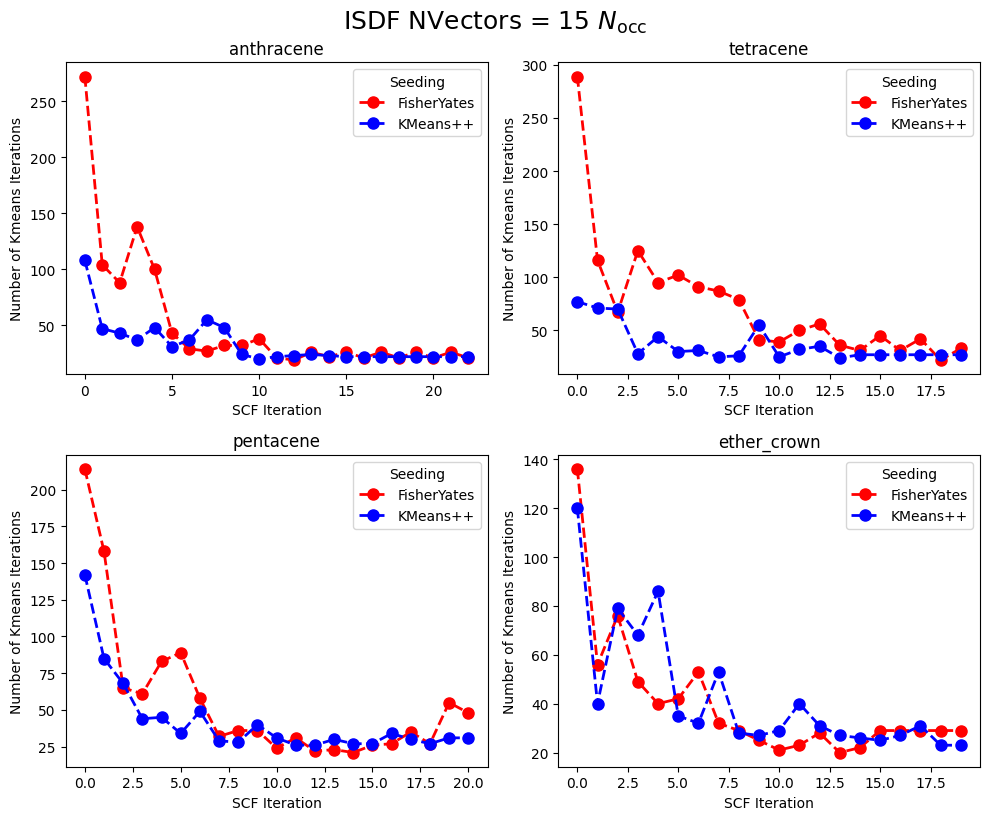

In [83]:
""" Weighted k-means convergence per SCF step, for each ISDF basis size
"""

fig, axes = plot_kmeans_iters_grid(molecules, fy_kmeans_itrs['5_nocc'], kmeanspp_kmeans_itrs['5_nocc'])
fig.suptitle(r'ISDF NVectors = 5 $N_{\text{occ}}$', fontsize=18, y=1.02)
    
fig, axes = plot_kmeans_iters_grid(molecules, fy_kmeans_itrs['7.5_nocc'], kmeanspp_kmeans_itrs['7.5_nocc'])
fig.suptitle(r'ISDF NVectors = 7.5 $N_{\text{occ}}$', fontsize=18, y=1.02)

fig, axes = plot_kmeans_iters_grid(molecules, fy_kmeans_itrs['10_nocc'], kmeanspp_kmeans_itrs['10_nocc'])
fig.suptitle(r'ISDF NVectors = 10 $N_{\text{occ}}$', fontsize=18, y=1.02)

fig, axes = plot_kmeans_iters_grid(molecules, fy_kmeans_itrs['15_nocc'], kmeanspp_kmeans_itrs['15_nocc'])
fig.suptitle(r'ISDF NVectors = 15 $N_{\text{occ}}$', fontsize=18, y=1.02)

In all cases, it speeds up the first iteration of WKM.

For the two larger sets of interpolation points, it results in a comparable or faster calculation
For the two smaller  sets of interpolation points, it results in a comparable or faster calculation for all but the ester crown, which k-means++ seeding is a demonstrably worse choice.



In [58]:
""" Timings of Fisher-Yates vs K-Means++

Parse data
"""
# Required to function changes to a module when running the kernel in tmux
import sys
sys.path.insert(0, "/home/bucchera/programs/isdfBenchmarks")

import importlib
import isdfbenchmarks.parser.profiling as profiling
importlib.reload(profiling)


molecules = ['anthracene', 'tetracene', 'pentacene', 'ether_crown']
isdf_basis = ['5_nocc', '7.5_nocc', '10_nocc', '15_nocc']
routines = ['SAMPLE_INITIAL_CENTROIDS', 'WEIGHTED_KMEANS', 'SCF_CYCLE']

fy_times = {subdir: {} for subdir in isdf_basis}
kpp_times = {subdir: {} for subdir in isdf_basis}

for subdir in isdf_basis:
    for molecule in molecules:
        cumulative, _ = profiling.parse_time(root_fy_wkm_all / subdir / molecule / "profiling/time.000000")
        fy_times[subdir][molecule] = {r: cumulative[r]['TOTAL_TIME'] for r in routines}

        cumulative, _ = profiling.parse_time(root_kmeanspp_wkm_all / subdir / molecule / "profiling/time.000000")
        kpp_times[subdir][molecule] = {r: cumulative[r]['TOTAL_TIME'] for r in routines}


Text(0.5, 1.02, 'ISDF NVectors = 15 $N_{\\text{occ}}$')

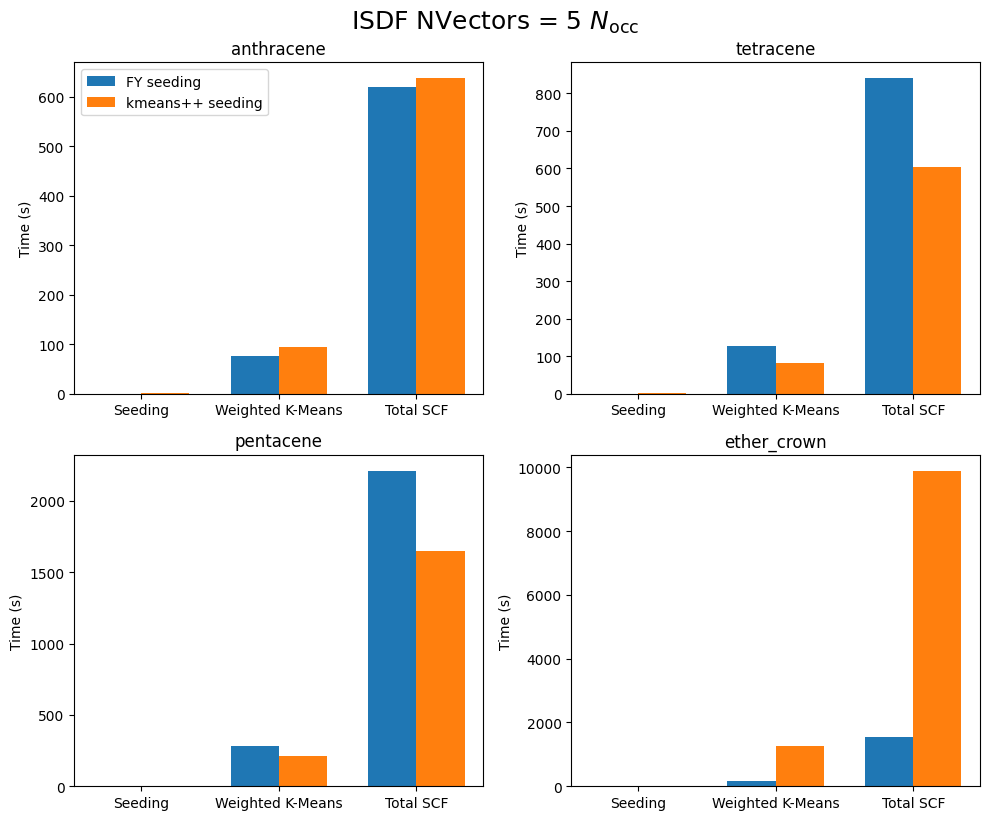

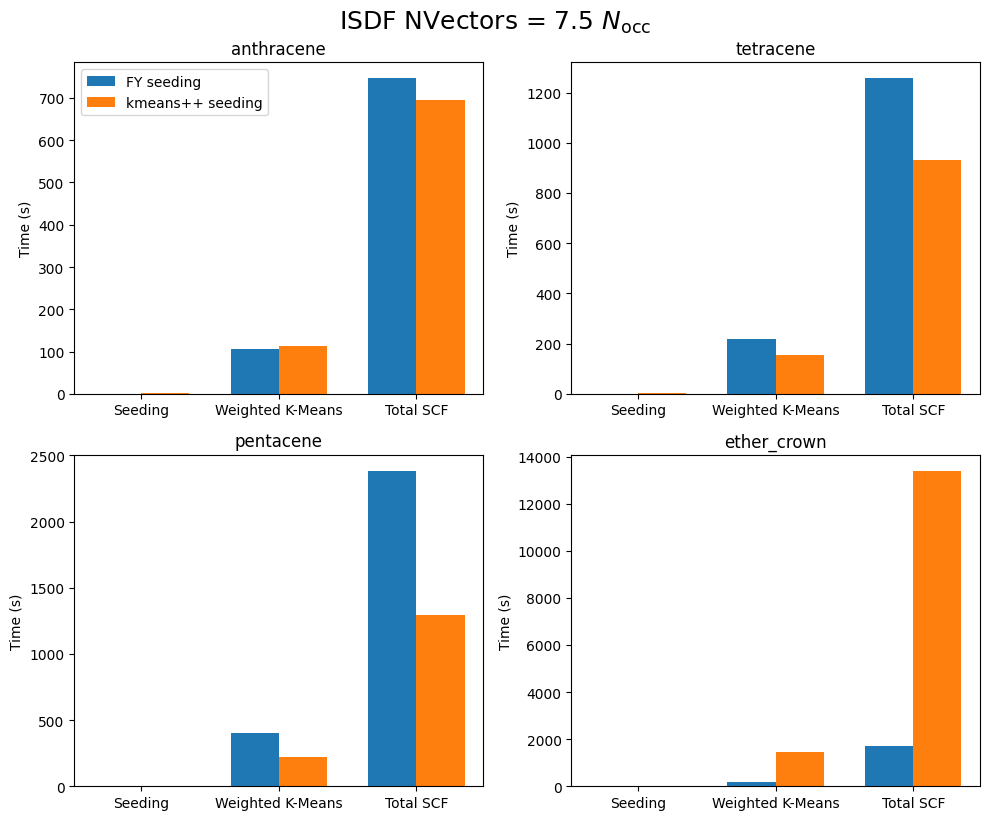

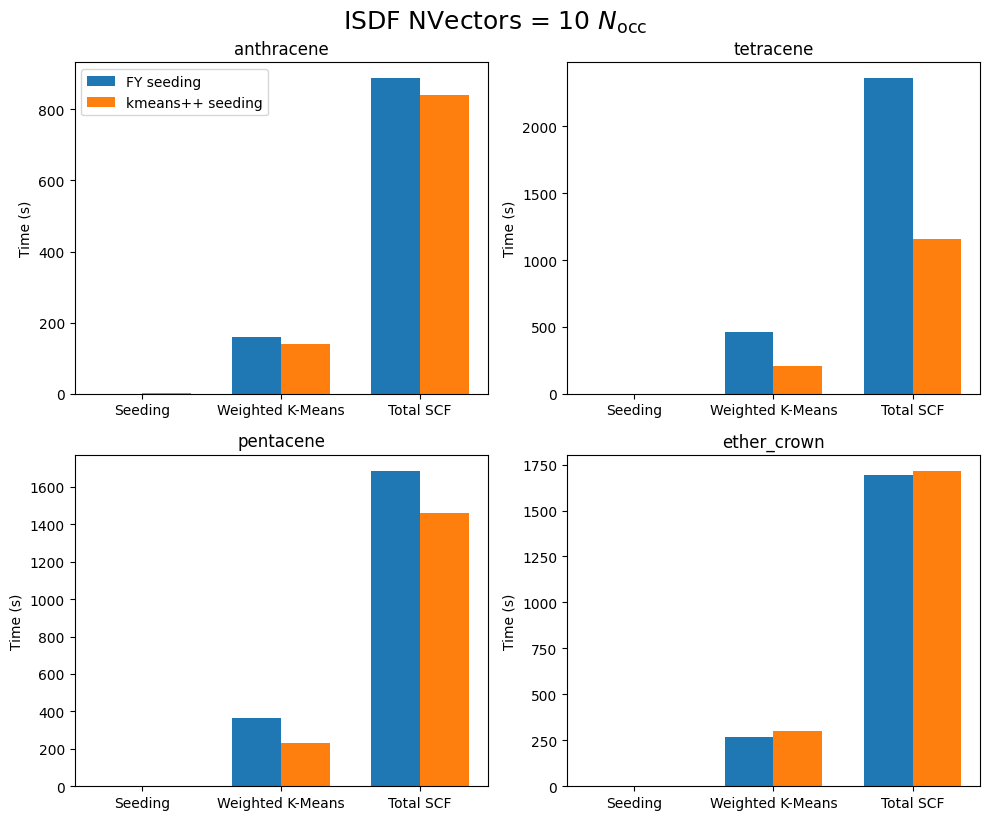

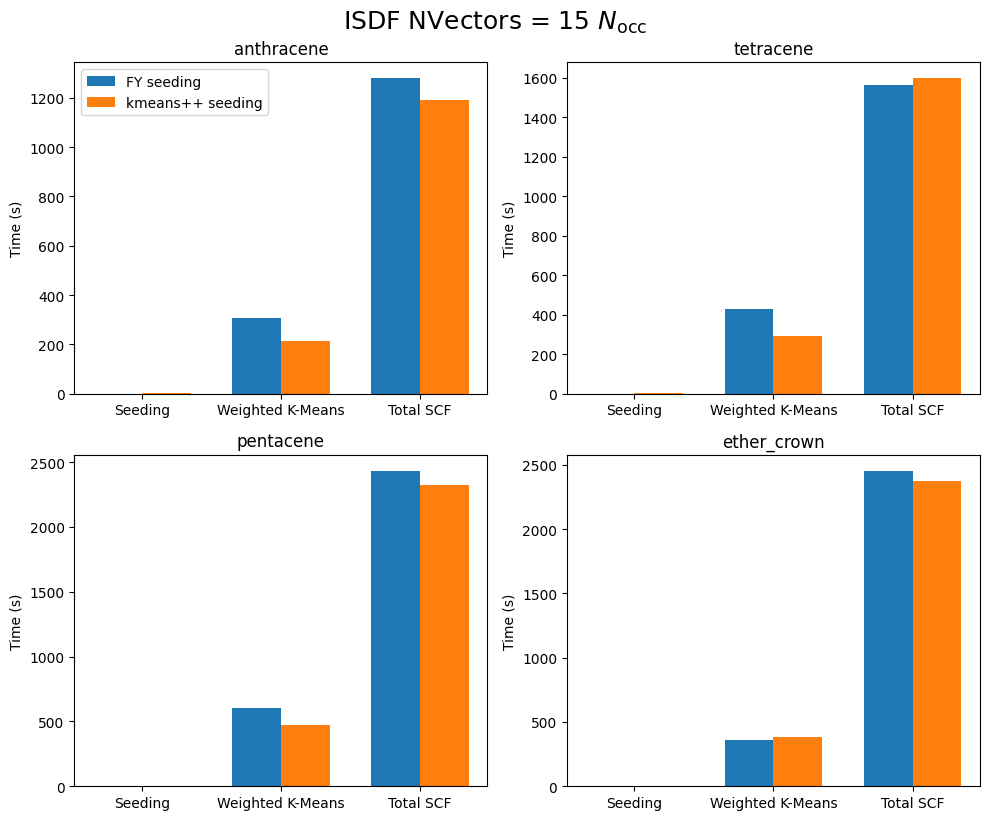

In [84]:
""" Timings of Fisher-Yates vs K-Means++

Plot: FY, Kmeans++, Total time spent in WKM, Total Cal time
"""

def subplot_timing_comparison(fig, axes, molecules, fy_t, kpp_t):
    for ax, molecule in zip(axes.ravel(), molecules):
        fy_vals  = [fy_t[molecule][k]  for k in list(fy_t[molecule])]
        kpp_vals = [kpp_t[molecule][k] for k in list(kpp_t[molecule])]
        
        x = np.arange(3) 
        width = 0.35
    
        ax.bar(x - width/2, fy_vals,  width, label='FY seeding')
        ax.bar(x + width/2, kpp_vals, width, label='kmeans++ seeding')
        ax.set_xticks(x)
        ax.set_xticklabels(['Seeding', 'Weighted K-Means', 'Total SCF'])
        ax.set_ylabel('Time (s)')
        ax.set_title(molecule)
    
    axes[0,0].legend()
    return fig, axes


fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig, axes = subplot_timing_comparison(fig, axes, molecules, fy_times['5_nocc'], kpp_times['5_nocc'])
fig.tight_layout()
fig.suptitle(r'ISDF NVectors = 5 $N_{\text{occ}}$', fontsize=18, y=1.02)

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig, axes = subplot_timing_comparison(fig, axes, molecules, fy_times['7.5_nocc'], kpp_times['7.5_nocc'])
fig.tight_layout()
fig.suptitle(r'ISDF NVectors = 7.5 $N_{\text{occ}}$', fontsize=18, y=1.02)

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig, axes = subplot_timing_comparison(fig, axes, molecules, fy_times['10_nocc'], kpp_times['10_nocc'])
fig.tight_layout()
fig.suptitle(r'ISDF NVectors = 10 $N_{\text{occ}}$', fontsize=18, y=1.02)

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig, axes = subplot_timing_comparison(fig, axes, molecules, fy_times['15_nocc'], kpp_times['15_nocc'])
fig.tight_layout()
fig.suptitle(r'ISDF NVectors = 15 $N_{\text{occ}}$', fontsize=18, y=1.02)


## Statements Based on the Timings

* In all systems tested, the cost of seeding with both methods is negligible.
* In most cases, one spends slightly less total time in the weighted-kmeans algorithm over all SCF iterations
    * This typically translates into overall less time spent performing the SCF
* The really large exception is the ether crown for the two lower-precision calcs (5 and 7.5* Nocc) that just run the max SCF limit - double check but pretty sure two occupied states just WILL NOT converge
* One **might** be able to avoid this by running several  kmeans++ calculations in parallel, and choosing the one with the lowest inertia (metric)
* If k-means++ lead to the same precision/error in exact energy, for a given number of ISDF vectors, then this would be pointless. But we expect that the improved weighted initial sampling should lower this
        


In [79]:
"""Parse exact exchange energies computed with each method
"""
import copy

from isdfbenchmarks.parser import static


molecules = ['anthracene', 'tetracene', 'pentacene', 'ether_crown']
isdf_basis = ['5_nocc', '7.5_nocc', '10_nocc', '15_nocc']

# Converged exact exchange energies, per molecule
ref_exx = {}
for molecule in molecules:
    ref_exx[molecule] = static.info_file(root_ace_ref / molecule)['Energy']['Exchange']

# Seeded with FY. WKM run once
isdf_exx_fy = {}
for molecule in molecules:
    # Energies as a function of the number of ISDF vectors (== c * Nocc)
    energies = np.empty(shape=len(isdf_basis))
    for i, subdir in enumerate(isdf_basis):
        energies[i] = static.info_file(root_fy_wkm_once / subdir / molecule)['Energy']['Exchange']
    isdf_exx_fy[molecule] = copy.deepcopy(energies)

# Seeded with K-means++. WKM run once
isdf_exx_kmeanspp = {}
for molecule in molecules:
    # Energies as a function of the number of ISDF vectors (== c * Nocc)
    energies = np.empty(shape=len(isdf_basis))
    for i, subdir in enumerate(isdf_basis):
        energies[i] = static.info_file(root_kmeanspp_wkm_once / subdir / molecule)['Energy']['Exchange']
    isdf_exx_kmeanspp[molecule] = copy.deepcopy(energies)

# Seeded with FY, running k-means for all SCF iterations
isdf_exx_fy_itrs = {}
for molecule in molecules:
    # Energies as a function of the number of ISDF vectors (== c * Nocc)
    energies = np.empty(shape=len(isdf_basis))
    for i, subdir in enumerate(isdf_basis):
        energies[i] = static.info_file(root_fy_wkm_all / subdir / molecule)['Energy']['Exchange']
    isdf_exx_fy_itrs[molecule] = copy.deepcopy(energies)

# Seeded with k-means++, running k-means for all SCF iterations
isdf_exx_kpp_itrs = {}
for molecule in molecules:
    # Energies as a function of the number of ISDF vectors (== c * Nocc)
    energies = np.empty(shape=len(isdf_basis))
    for i, subdir in enumerate(isdf_basis):
        energies[i] = static.info_file(root_kmeanspp_wkm_all / subdir / molecule)['Energy']['Exchange']
    isdf_exx_kpp_itrs[molecule] = copy.deepcopy(energies)    
    

In [80]:
"""Plot function for the error as a function of ISDF vector basis size
"""
import numpy as np

# Pre-factors to get total number of ISDF vectors
prefactors = [5.0, 7.5, 10.0, 15.0]
n_atoms = {"anthracene": 24.0, "tetracene": 30.0, "pentacene": 36.0, "ether_crown": 42.0}


def plot_error_line_plot(ref_exx, exx_fy, exx_kmeanspp):
    # Plot settings
    settings = {'anthracene':   {'color': 'blue',   'linewidth': 2, 'markersize': 8},
                'tetracene':    {'color': 'orange', 'linewidth': 2, 'markersize': 8}, 
                'pentacene':    {'color': 'green',  'linewidth': 2, 'markersize': 8},
                'ether_crown':  {'color': 'red',    'linewidth': 2, 'markersize': 8}
              }
        
    for molecule in molecules:
        exx_error = ( np.abs(exx_fy[molecule] - ref_exx[molecule])) / n_atoms[molecule]
        plt.plot(prefactors, exx_error, 'x-', label=molecule, **settings[molecule])
    
    settings = {'anthracene':   {'color': 'blue',   'linewidth': 2, 'markersize': 8, 'markerfacecolor':'none', 'markeredgewidth': 1.5},
                'tetracene':    {'color': 'orange', 'linewidth': 2, 'markersize': 8, 'markerfacecolor':'none', 'markeredgewidth': 1.5}, 
                'pentacene':    {'color': 'green',  'linewidth': 2, 'markersize': 8, 'markerfacecolor':'none', 'markeredgewidth': 1.5},
                'ether_crown':  {'color': 'red',    'linewidth': 2, 'markersize': 8, 'markerfacecolor':'none', 'markeredgewidth': 1.5}
              }
    
    for molecule in molecules:
        exx_error = np.abs(exx_kmeanspp[molecule] - ref_exx[molecule]) / n_atoms[molecule]
        plt.plot(prefactors, exx_error, 'o--', label=molecule,  **settings[molecule])
    
    plt.xlabel(r"ISDF Basis Size ($c N_{occ}$)")
    plt.ylabel("Error in Exact Exchange Energy (Ha / Atom)")
    plt.yscale('log')
    xmin, xmax = plt.xlim() 
    plt.hlines(1.e-6, xmin, xmax, colors="black", linestyles='dashed')
    plt.xlim(xmin, xmax)
    plt.legend()

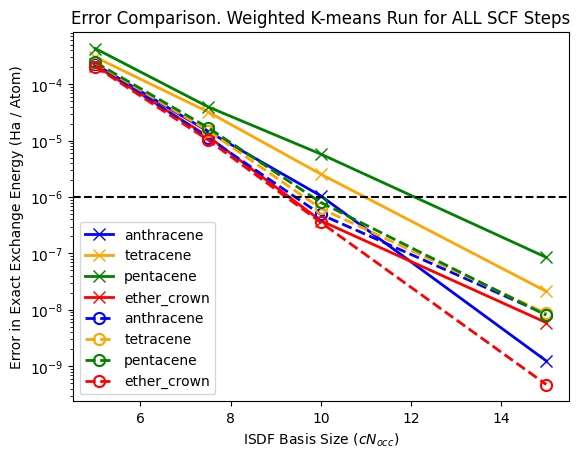

Crosses denote FY, whereas open circles denote K-Means++


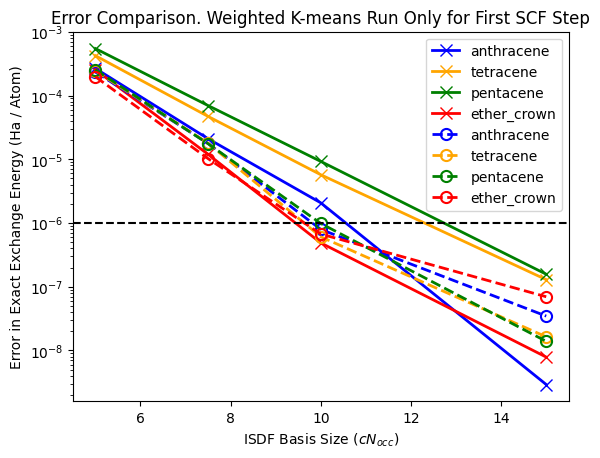

Crosses denote FY, whereas open circles denote K-Means++


In [82]:
""" Plot the error in exact exchange energy as a function of ISDF vector basis size
"""

# For weighted kmeans on all SCF iterations
plot_error_line_plot(ref_exx, isdf_exx_fy_itrs, isdf_exx_kpp_itrs)
plt.title('Error Comparison. Weighted K-means Run for ALL SCF Steps')
plt.show()
print('Crosses denote FY, whereas open circles denote K-Means++')

# For weighted kmeans on the first SCF iteration
plot_error_line_plot(ref_exx, isdf_exx_fy, isdf_exx_kmeanspp)
plt.title('Error Comparison. Weighted K-means Run Only for First SCF Step')
plt.show()
print('Crosses denote FY, whereas open circles denote K-Means++')



In general, the improvement in EXX from seeding with kmeans++ increases with ISDF point set size (some exceptions)

For approximately the same number of ISDF vectors, and the same execution time. 

When running WKM on all SCF iterations:
* Anthracene: 
    * Approximately unchanged for all sets of ISDF points, except the large, where kmeans++ actually worsens the result
    * Can obtain < $1.e^{-6}$ per atom for 10 $N_{occ}$, rather than 10.25 $N_{occ}$
* Tetracene: Can obtain < $1.e^{-6}$ per atom for 10 $N_{occ}$, rather than 11 $N_{occ}$
* Pentacene: Can obtain < $1.e^{-6}$ per atom for 10 $N_{occ}$, rather than 12 $N_{occ}$
* Ether crown: Identical precision for 10 $N_{occ}$. Maximise achievable precision (15 $N_{occ}$) improved by an order of magnitude by using k-means++

When running WKM on just the first iteration:
* Anthracene: More or less the same result as when running WKM on all SCF iterations, except for the overall precision in EXX achieveable for the largest set of points. This is an order of magnitude larger than running WKM on all iterations.
* Tetracene: Can achieve the same precision without needing to run WKM on each step. 
* Pentacene: Can (more or less) achieve the same precision without needing to run WKM on each step. 
* Ether crown: Very slightly worse w.r.t WKM on all SCF steps. One-shot precision for the large set (15 $N_{occ}$) is considerably worse than with FY one-shot, and clearly requires WKM per SCF to really refine.


I think all these results show that the algorithm is very sensitive to the starting point, and will converge to some local minimum.


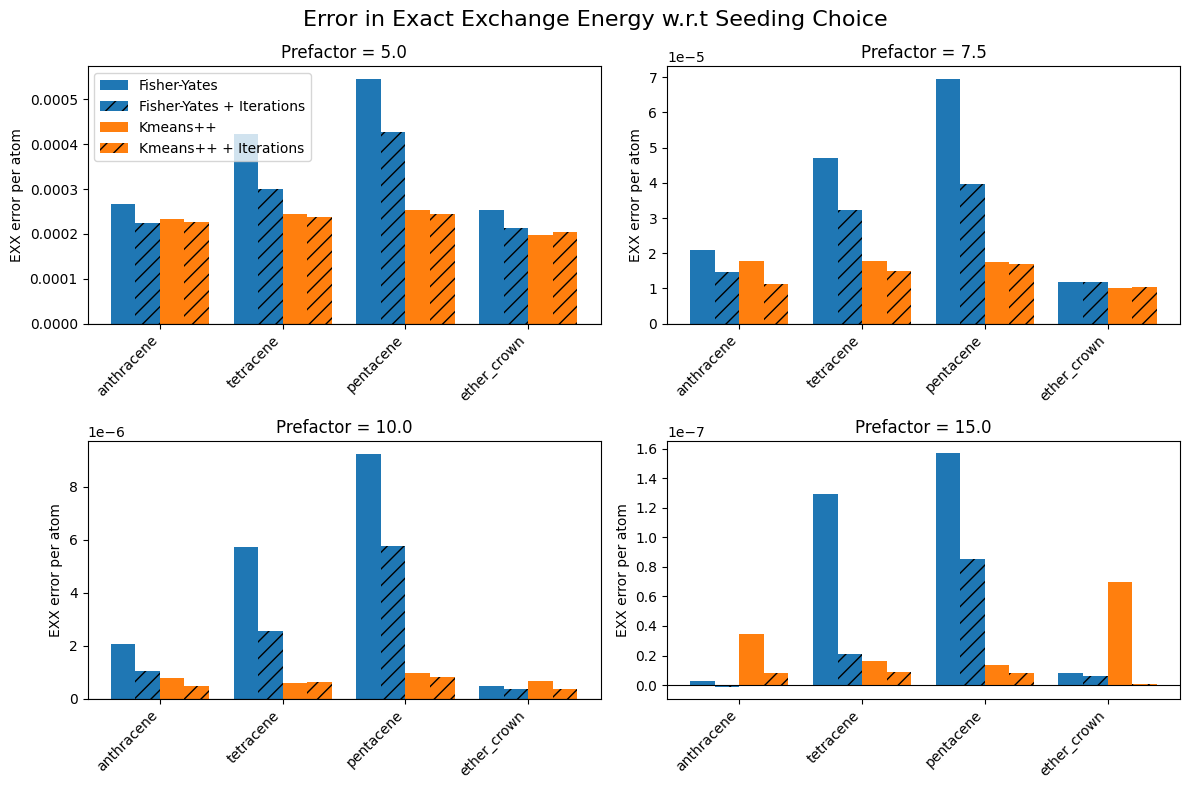

`+ Iterations` means run weighted k-means on every SCF step, rather than just the first


In [87]:
""" Additional Error Comparison as a Function of Seeding Method
"""
import numpy as np
import matplotlib.pyplot as plt

prefactors = [5.0, 7.5, 10.0, 15.0]
n_atoms = {"anthracene": 24.0, "tetracene": 30.0,
           "pentacene": 36.0, "ether_crown": 42.0}
molecules = list(n_atoms.keys())
isdf_subdirs = ['5_nocc', '7.5_nocc', '10_nocc', '15_nocc']



settings = {
    'anthracene':  {'color': 'blue',   'linewidth': 2, 'markersize': 8},
    'tetracene':   {'color': 'orange', 'linewidth': 2, 'markersize': 8},
    'pentacene':   {'color': 'green',  'linewidth': 2, 'markersize': 8},
    'ether_crown': {'color': 'red',    'linewidth': 2, 'markersize': 8},
}

methods = {
    "fy": {
        "label": "Fisher-Yates",
        "color": "C0",
        "hatch": ''
    },
    "fy_itrs": {
        "label": "Fisher-Yates + Iterations",
        "color": "C0",
        "hatch": '//'
    },
    "kpp": {
        "label": "Kmeans++",
        "color": "C1",
        "hatch": ''
    },
    "kpp_itrs": {
        "label": "Kmeans++ + Iterations",
        "color": "C1",
        "hatch": '//'
    }
}

errors = {key: {} for key in methods}

for mol in molecules:
    errors["fy"][mol] = (np.array(isdf_exx_fy[mol]) - ref_exx[mol]) / n_atoms[mol]
    errors["fy_itrs"][mol] = (np.array(isdf_exx_fy_itrs[mol]) - ref_exx[mol]) / n_atoms[mol]
    errors["kpp"][mol] = np.abs(np.array(isdf_exx_kmeanspp[mol]) - ref_exx[mol]) / n_atoms[mol]
    errors["kpp_itrs"][mol] = np.abs(np.array(isdf_exx_kpp_itrs[mol]) - ref_exx[mol]) / n_atoms[mol]


n_mols = len(molecules)
x = np.arange(n_mols)  # positions for the molecule groups
method_keys = list(methods.keys())
n_methods = len(method_keys)
bar_width = 0.8 / n_methods  # total width ~0.8, split among methods

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()

    # Reference error is zero by definition
for i_pref, (ax, pref) in enumerate(zip(axes, prefactors)):
    for i_meth, mkey in enumerate(method_keys):
        offset = (i_meth - (n_methods - 1) / 2) * bar_width
        values = [errors[mkey][mol][i_pref] for mol in molecules]

        ax.bar(
            x + offset,
            values,
            width=bar_width,
            label=methods[mkey]["label"] if i_pref == 0 else None,  # legend only once
            color=methods[mkey]["color"],
            hatch=methods[mkey]["hatch"]
        )

    ax.set_title(f"Prefactor = {pref}")
    ax.set_xticks(x)
    ax.set_xticklabels(molecules, rotation=45, ha="right")
    ax.axhline(0.0, color="black", linewidth=0.8)
    ax.set_ylabel("EXX error per atom")

# Put one legend outside or on the first axis
axes[0].legend(loc="best")

fig.suptitle("Error in Exact Exchange Energy w.r.t Seeding Choice", fontsize=16)

fig.tight_layout()
plt.show()
print("`+ Iterations` means run weighted k-means on every SCF step, rather than just the first")